In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
train= pd.read_csv('train.csv',encoding='big5')
class1 = train[train.Class==1]
class0 = train[train.Class==0]

In [3]:
# duplicate fraud case: 2 times
train= class0.append([class1,class1], ignore_index=True)
test= pd.read_csv('test_public.csv',encoding='big5')
# append in ONE data
test = test.dropna()
data=train.append(test, ignore_index=True)
del (class0,class1,train,test)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
# split into training and testing data by Class
dataTrain = data[pd.notnull(data['Class'])]#.sort_values(by=["Time"])
dataTest = data[~pd.notnull(data['Class'])]#.sort_values(by=["Time"])
dataTrain.columns
del data

In [5]:
#dataTrain = dataTrain.drop(['Time'], axis=1)
dataTest = dataTest.drop(['TXKEY','Class'], axis=1)
X_feature = dataTrain.drop(['TXKEY','Class'], axis=1)
y_t =dataTrain['Class']
del dataTrain

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.33, random_state=2884)

In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [8]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 64,
    'num_trees': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_leaf = 64

In [9]:
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train)

print('Save model...')
# save model to file
gbm.save_model('model.txt')

Start training...


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.0157037
[2]	training's binary_logloss: 0.014978
[3]	training's binary_logloss: 0.0144075
[4]	training's binary_logloss: 0.0139119
[5]	training's binary_logloss: 0.0134584
[6]	training's binary_logloss: 0.0130036
[7]	training's binary_logloss: 0.0126051
[8]	training's binary_logloss: 0.0122215
[9]	training's binary_logloss: 0.0118904
[10]	training's binary_logloss: 0.0115731
[11]	training's binary_logloss: 0.0112641
[12]	training's binary_logloss: 0.0109791
[13]	training's binary_logloss: 0.0107087
[14]	training's binary_logloss: 0.0104751
[15]	training's binary_logloss: 0.0102461
[16]	training's binary_logloss: 0.0100247
[17]	training's binary_logloss: 0.00981905
[18]	training's binary_logloss: 0.00962466
[19]	training's binary_logloss: 0.00943474
[20]	training's binary_logloss: 0.00925718
[21]	training's binary_logloss: 0.00908843
[22]	training's binary_logloss: 0.00892642
[23]	training's binary_logloss: 0.008769
[24]	training's binary_logloss: 0.00861

In [10]:
print('Start predicting...')
# predict and get data on leaves, training data
y_pred = gbm.predict(X_train, pred_leaf=True)

print(np.array(y_pred).shape)
print(y_pred[:3])

Start predicting...
(133797, 100)
[[59 54 52 62 40 40 42 41 51 56 39 49 37 59 31 62 59 62 61 24 33 46 51 59
  54 62 57 57 56 63 41 42 42 40 40 45 45 38 34 46 59 29 63 29 39 33 39 24
  10 61 37 34 34  1  1 53 57 38 43 36 43 55 56 21 60 62 23 54 11 11 39 47
   7 53 47 17 19 20 16 17 12 12 22 11  7 47 63 12 36 12 62 20 18 18 43 35
  34 16 16 16]
 [59 54 52 62 40 40 42 53 40 56 39 49 37 59 31 62 59 62 61 24 33 46 51 59
  54 62 57 57 56 63 59 42 58 40 61 35 45 38 34 46 59 29 63 29 39 33 60 24
  10 61 37 34 34 39 12 53 57 38 43 36 43 55 56 14 60 17 23 54 11 11 39 47
   7 53 47 17 19 20 16 17 12 12 14 11  7 47 63 12 36 12 62 20 18 18 43 35
  34 16 16 16]
 [59 54 52 62 40 40 42 41 51 56 14 49 13 57 50 62 59 62 61 62 53 46 51 59
  54 62 57 57 56 63 41 53 42 40 40  6  8  8  8 46  6 19 63 27 18 62 53 24
   9 28 28 54  4 16 14 53 57 28 35 28 43 12 46 38 43 14  3 43  3  3 39 47
   7 53 47  5  5  6  6  5 20 20  5 39 19 16 14 14 36 14 62 35  4  4  4 35
  34 15  7  7]]


In [11]:
print('Writing transformed training data')
transformed_training_matrix = np.zeros([len(y_pred), len(y_pred[0]) * num_leaf], dtype=np.int32)  # N * num_tress * num_leafs

Writing transformed training data


In [12]:
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf + np.array(y_pred[i])
    transformed_training_matrix[i][temp] += 1

In [13]:
y_pred = gbm.predict(X_test, pred_leaf=True)
print('Writing transformed validating data')
transformed_validating_matrix = np.zeros([len(y_pred), len(y_pred[0]) * num_leaf], dtype=np.int32)
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf + np.array(y_pred[i])
    transformed_validating_matrix[i][temp] += 1

Writing transformed validating data


In [14]:
print(np.array(y_pred).shape)
print(y_pred[:3])

(65901, 100)
[[59 63 57 62 40 37 38 41 51 33 63 53 61 59 58 62 59 62 61 24 33 54 59 59
  60 54 54 55 53 61 41 42 42 40 40 45 62 58 57 63 59  1 36 10 57 18 39 25
  10 62 13 13 12  1  1  9 24 43 47 41 60 30 30 21 16 62 26 22  8  8 34  1
  26  1  1  1  1  1  1  1 23 38 22 52 47 47 63 12 36 12 28  1  1  1 43 51
  52 63 21 21]
 [59 54 52 62 40 40 42 41 51 56 39 49 37 59 31 62 59 62 61 24 33 46 51 59
  54 62 57 57 56 63 41 42 42 40 40 45 45 38 34 46 59 29 63 29 39 33 39 24
  10 61 37 34 34  1  1 53 57 38 43 36 43 55 56 21 60 62 23 54 11 11 39 47
   7 53 47 17 19 20 16 17 12 12 22 11  7 47 63 12 36 12 62 20 18 18 43 35
  34 16 16 16]
 [59 54 52 62 40 40 42 41 51 56 39 49 37 59 31 62 59 62 61 24 33 46 51 59
  54 62 57 57 56 63 41 42 42 40 40 45 45 38 34 46 59 29 63 29 39 33 39 24
  10 61 37 34 34  1  1 53 57 38 43 36 43 55 56 21 60 62 23 54 11 11 39 47
   7 53 47 17 19 20 16 17 12 12 22 11  7 47 63 12 36 12 62 20 18 18 43 35
  34 16 16 16]]


In [15]:
lr = LogisticRegression(penalty='l2',C=0.16) # logistic model construction
lr.fit(transformed_training_matrix, y_train)  # fitting the data
y_pred_val = lr.predict(transformed_validating_matrix)   # Give the probabilty on each label

In [16]:
f1_score(y_test,y_pred_val,average=None)

array([0.99993912, 0.9800995 ])

In [21]:
del transformed_training_matrix

In [17]:
def get_lift(prob_data):
    prob_data=prob_data.sort_values(by=['Prob'],ascending=False).reset_index(drop=True)
    prob_data['cnt']=1.0
    prob_data['cumsum']=prob_data.Y.cumsum()
    prob_data['cum_cnt'] = prob_data.cnt.cumsum()
    prob_data['precision'] = prob_data['cumsum']/prob_data['cum_cnt']
    prob_data['recall'] = prob_data['cumsum']/prob_data['cumsum'].max()
    lift_data = prob_data[['precision','recall']].groupby(['recall']).min().reset_index()
    lift_data['f1'] = (2*lift_data.precision*lift_data.recall)/(lift_data.precision+lift_data.recall)
    return lift_data

In [18]:
result = pd.DataFrame(data={'Y':y_test,'Prob':y_pred_val})
result_lift = get_lift(result)

In [19]:
result_lift=result_lift.iloc[1:,:]
result_lift[result_lift.f1==result_lift.f1.max()]

,recall,precision,f1
195,0.98,0.975124,0.977556


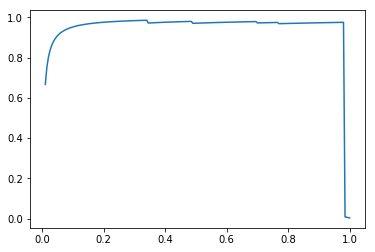

In [20]:
plt.plot(result_lift.recall,result_lift.precision)

In [22]:
lgb_train = lgb.Dataset(X_feature, y_t)

In [23]:
print('Start predicting...')
# predict and get data on leaves, training data
y_pred = gbm.predict(X_feature, pred_leaf=True)

Start predicting...


In [24]:
print('Writing transformed training data')
transformed_training_matrix = np.zeros([len(y_pred), len(y_pred[0]) * num_leaf], dtype=np.int32)  # N * num_tress * num_leafs

Writing transformed training data


In [25]:
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf + np.array(y_pred[i])
    transformed_training_matrix[i][temp] += 1

In [26]:
lr = LogisticRegression(penalty='l2',C=0.16) # logistic model construction
lr.fit(transformed_training_matrix, y_t)  # fitting the data

LogisticRegression(C=0.16, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
y_pred_train = lr.predict(transformed_training_matrix)   # Give the probabilty on each label
f1_score(y_t,y_pred_train,average=None)

array([0.99998493, 0.9955157 ])

In [28]:
submit = pd.read_csv('sampleSubmission.csv',encoding='big5')
TXKEY =np.array(submit["TXKEY"])
X_test = dataTest

In [29]:
y_pred = gbm.predict(X_test, pred_leaf=True)

print(np.array(y_pred).shape)
print(y_pred[:3])

(85443, 100)
[[43 38 45 39 30 39 40 39 40 35 39 49 37 59 31 62 59 62 61 24 34 35 33 36
  29 62 57 57 56 63 42 45 43 41 41 35 45 38 47  4 59 63 63 29 39 33 34 32
  10 61 62 62 34 13 12 58 48 38 43 36 19 55 56 14 53 17 23 55 11 11 20 32
  29 29 27 17 19 20 16 36 12 12 14 11  7 44 43 12 40 12 62 63 18 18 11 46
  47 16 16 16]
 [59 54 52 62 40 40 42 41 51 56 39 49 37 59 31 62 59 62 61 24 33 46 51 59
  54 62 57 57 56 63 41 42 42 40 40 45 45 38 34 46 59 29 63 29 39 33 39 24
  10 61 37 34 34  1  1 53 57 38 43 36 43 55 56 21 60 62 23 54 11 11 39 47
   7 53 47 17 19 20 16 17 12 12 22 11  7 47 63 12 36 12 62 20 18 18 37 35
  34 16 16 16]
 [55 57 57 50 40 37 38 41 51 33 31 53 32 59 29 46 40 33 40 45 33 54 59 59
  58  2  1  2  2  2 41 42 42 40 40 45 62 58 22 63 28 17  2 21 20 34 39 25
  60 57 43 40 40  1  1 21 10 15 31 20 37 30 30 21 16  8 26 22  8  8  4  1
  26  1  1 24 26 27 23 25  1  1 22  1 47 47 63 46  7 44 55 26 29 28 43 10
  10 34 43 14]]


In [30]:
transformed_testing_matrix = np.zeros([len(y_pred), len(y_pred[0]) * num_leaf], dtype=np.int64)
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf + np.array(y_pred[i])
    transformed_testing_matrix[i][temp] += 1

In [31]:
y_pred_test = lr.predict_proba(transformed_testing_matrix)   # Give the probabilty on each label

In [32]:
df_p = pd.DataFrame({'p0':y_pred_test[:,0],'p1':y_pred_test[:,1]})

In [36]:
#submit = pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'Class', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[134,3])
out.Class[out.p1>=out.iloc[134,3]]=1

偽冒機率門檻： 0.5251639050001263


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
ttl= out['Class'].sum()
ttl

135

In [38]:
out=out[['TXKEY','Class']]
out.to_csv("CCTXN_to_kaggle.csv", index= False)

In [39]:
print('This submission: public score: 0.88888')

This submission: public score: 0.88888
